In [1]:
import os
import librosa
import matplotlib
import scipy 
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from scipy.signal import lfilter
import soundfile as sf
from noisereduce import reduce_noise
import phast

import plotting
import utils

In [2]:
PATH = "/home/nobeljpde1/abt/data/din/025.wav" #phast.SOUNDS['violin']
NAME = os.path.basename(PATH).split(".")[0]

strategy = 'specres'
OUTPUT_NAME = f"{NAME}_reconstructed_{strategy}"

N_MELS = 128
N_FFT = 512
N_HOP = 32

MIN_FREQ = 450
MAX_FREQ = 5500
CS = True
scaling_factor = 1.4
n_trials = 20
BINSIZE = 18e-6 * 2
apply_premph = False

MEL_SCALE = librosa.filters.mel_frequencies(N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ) 

def pre_emphasis(signal: np.ndarray, factor: float = 0.97):
    return np.append(signal[0], signal[1:] - (factor * signal[:-1]))

if strategy == "specres":
    OUTPUT_NAME = f"{OUTPUT_NAME}_cs{CS}_preemph{apply_premph}"

In [3]:
if strategy == 'ace':
    tp = phast.load_cochlear()    
    (audio_signal, FS), pulse_train, neurogram = phast.ace_e2e(
        PATH,
        tp=tp,
        scaling_factor=scaling_factor,
        n_trials = n_trials,
    )
    
else:
    tp = phast.load_df120()
    audio_signal, audio_fs = phast.scs.ab.frontend.read_wav(PATH)
    if apply_premph:
        audio_signal = pre_emphasis(audio_signal[0]).reshape(1, -1)
    
    (audio_signal, FS), pulse_train, neurogram = phast.ab_e2e(
        audio_signal=audio_signal, 
        audio_fs=audio_fs,
        tp=tp,
        current_steering=CS, 
        scaling_factor=scaling_factor,
        n_trials = n_trials
    )
    audio_signal = audio_signal[0]

/home/nobeljpde1/abt/venv/lib/python3.11/site-packages/phast/scs/ab/filterbank.py:152: RuntimeWarning: divide by zero encountered in log2
  env[i, :] = np.log2(env[i, :])
/home/nobeljpde1/abt/venv/lib/python3.11/site-packages/phast/scs/ab/noise_reduction.py:94: RuntimeWarning: divide by zero encountered in log10
  logA = np.maximum(-100, 20 * np.log10(A))


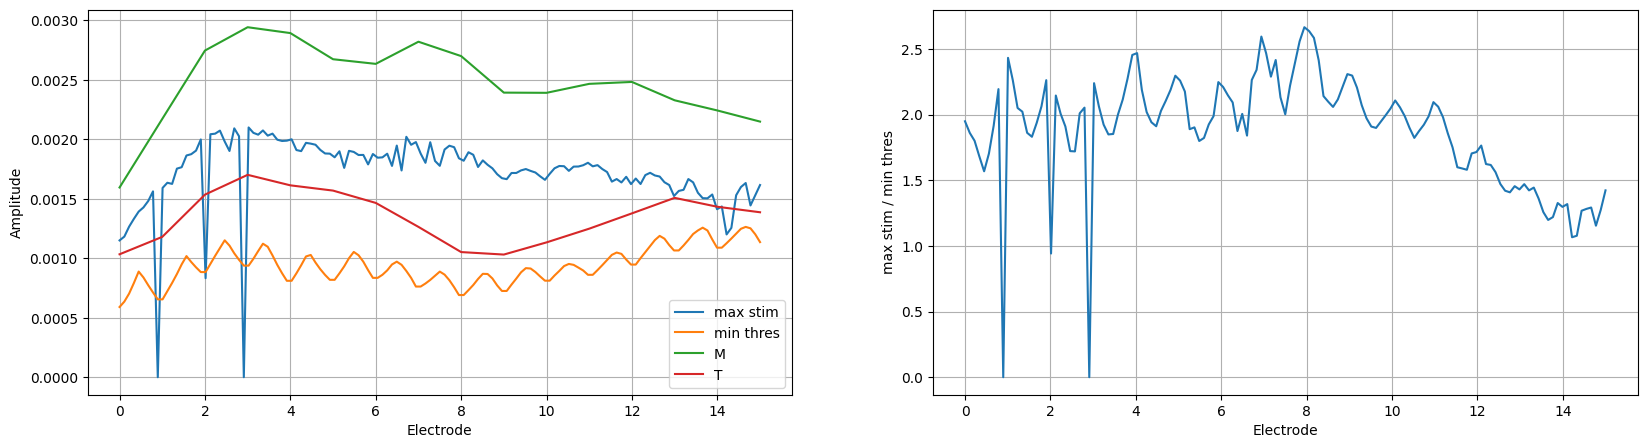

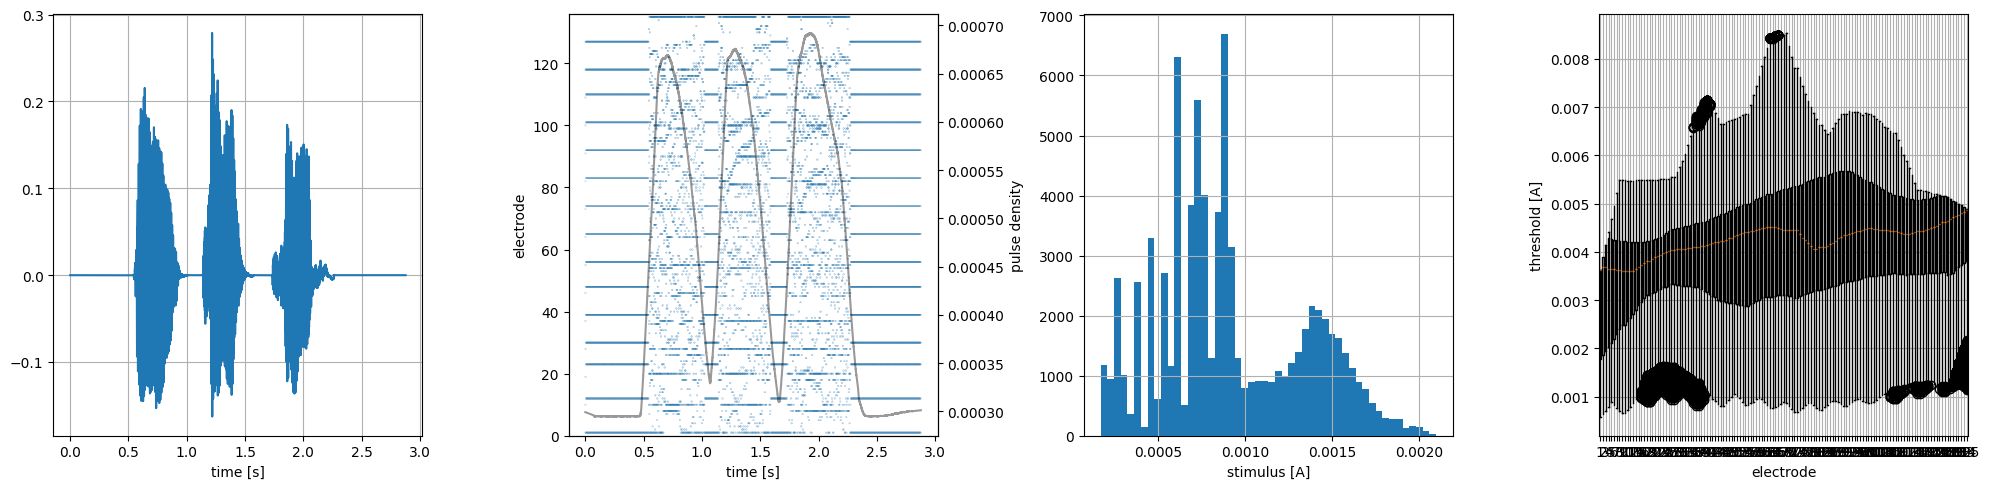

In [4]:
plotting.plot_pulse_train_stats(pulse_train, audio_signal, tp.electrode.m_level, tp.electrode.t_level, tp.electrode.pw, tp.i_det, FS, 21 if strategy == 'ace' else 15)

array([], shape=(0, 2), dtype=int64)

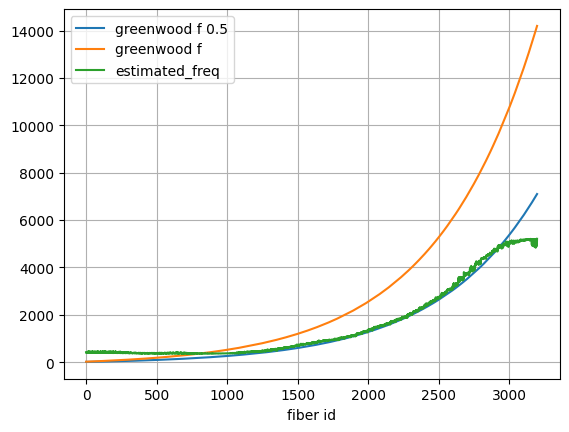

In [5]:
cycle = 2 * 15
cycle_time = cycle * 18e-6
n_channels = pulse_train.shape[0]

# This is incorrect
channel_freq = phast.scs.ab.defaults.virtual_channel_frequencies(n_channels, MAX_FREQ + 500)

power = 25
w = (-tp.i_det / tp.i_det.sum(axis=1).reshape(-1, 1)) + (2 / len(channel_freq))
w = np.power(w, power) / np.power(w, power).sum(axis=1).reshape(-1, 1)

estimated_freq = w @ channel_freq
plt.figure()
plt.plot(tp.greenwood_f * .5, label="greenwood f 0.5")
plt.plot(tp.greenwood_f, label="greenwood f")
plt.plot(estimated_freq, label="estimated_freq")

plt.xlabel("fiber id")
plt.legend()
plt.grid()


fiber_freq = estimated_freq

values, counts = np.unique_counts(np.digitize(fiber_freq, MEL_SCALE))

missing_freq_bins = np.array(list(set(range(80)) - set(values)), dtype=int)

np.c_[missing_freq_bins, MEL_SCALE[missing_freq_bins]].astype(int)

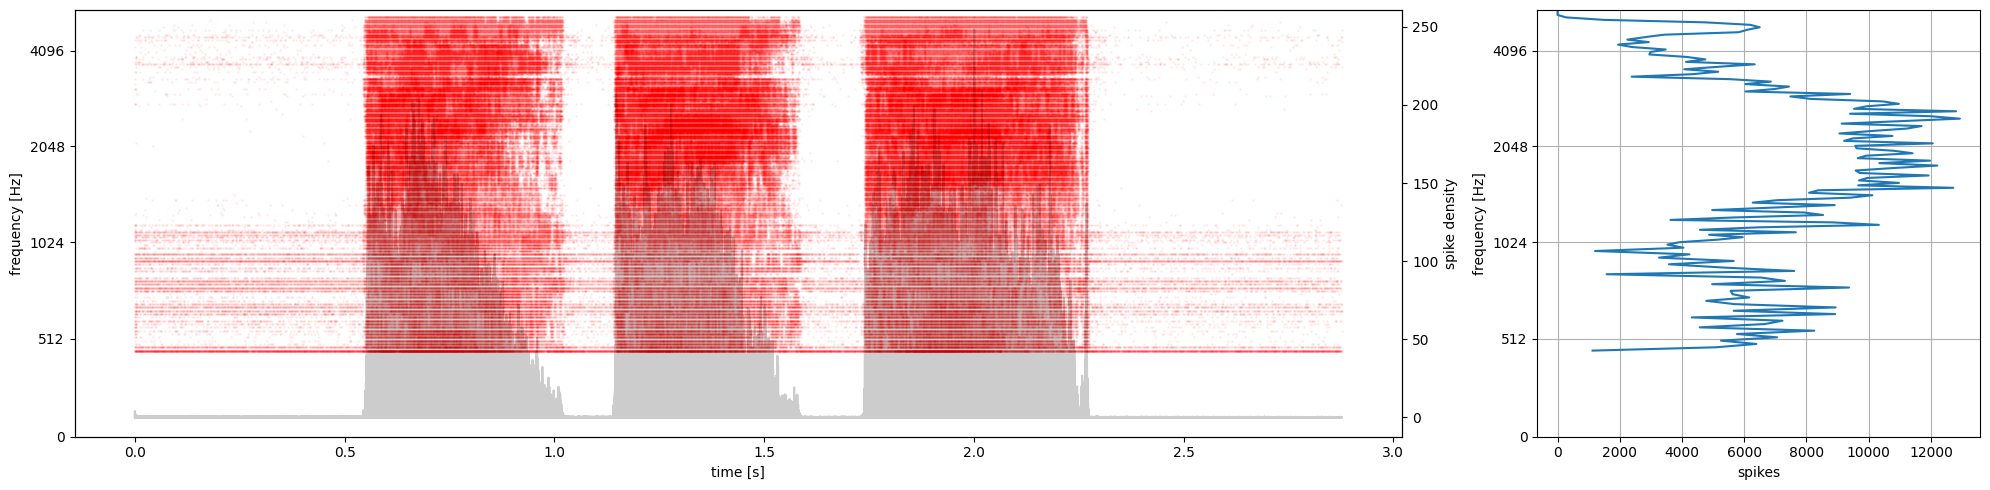

In [6]:
neurogram_freq_bin = utils.bin_over_y(neurogram.data, fiber_freq, MEL_SCALE, agg=np.mean)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), width_ratios=[3, 1])
for i in range(N_MELS):
    x = np.where(neurogram_freq_bin[i])[0]
    ax1.scatter(x * BINSIZE, MEL_SCALE[i] * np.ones(len(x)), color="red", alpha=.05, s=1)
    
density = neurogram_freq_bin.sum(axis=0)
ax3 = ax1.twinx()
ax3.plot(np.arange(len(density)) * BINSIZE, density, alpha=.2, color="black", zorder=-1)
ax3.set_ylabel("spike density")
      
ax2.plot(neurogram_freq_bin.sum(axis=1), MEL_SCALE)
ax2.grid()
ax2.set_xlabel("spikes")
plotting.frequency_ax(ax2)
plotting.time_vs_freq(ax1)
ax2.set_ylim(0, MAX_FREQ)
ax1.set_ylim(0, MAX_FREQ)
plt.tight_layout();  

In [7]:
from matplotlib.colors import LogNorm, Normalize
def plot_heatmap(
    t, y, data, 
    ax=None, fig=None, 
    show_bands: bool = True, 
    pad_idx: bool = False,
    figsize=(9, 4),
    logcolors: bool = False
):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    norm = LogNorm(vmin=data.min(), vmax=data.max()) if logcolors else Normalize(vmin=data.min(), vmax=data.max())

    if pad_idx:
        n_idx = np.nonzero(data.sum(axis=0))[0]
        n_idx = np.unique(np.c_[n_idx - 1, n_idx, n_idx + 1].ravel())
        n_idx = n_idx[n_idx < t.size]
        img = ax.pcolormesh(
            t[n_idx], y, data[:, n_idx], cmap="inferno", norm=norm
            
        )
    else:
        img = ax.pcolormesh(
            t[:], y, data[:, :], cmap="coolwarm", norm=norm
        )
    plotting.time_vs_freq(ax)
    ax.set_xlabel("time [s]")
    fig.colorbar(img, ax=ax)
    
    if show_bands:
        for f in y:
            ax.plot([0, t[-1]], [f, f], color="white", alpha=0.3)
        ax.set_xlim(0, t[-1])

# plot_heatmap(np.linspace(0, duration, neurogram_freq_bin.shape[1]), MEL_SCALE, neurogram_freq_bin, show_bands=False, logcolors=False)
# phast.plot_neurogram(neurogram)

(128, 1565)

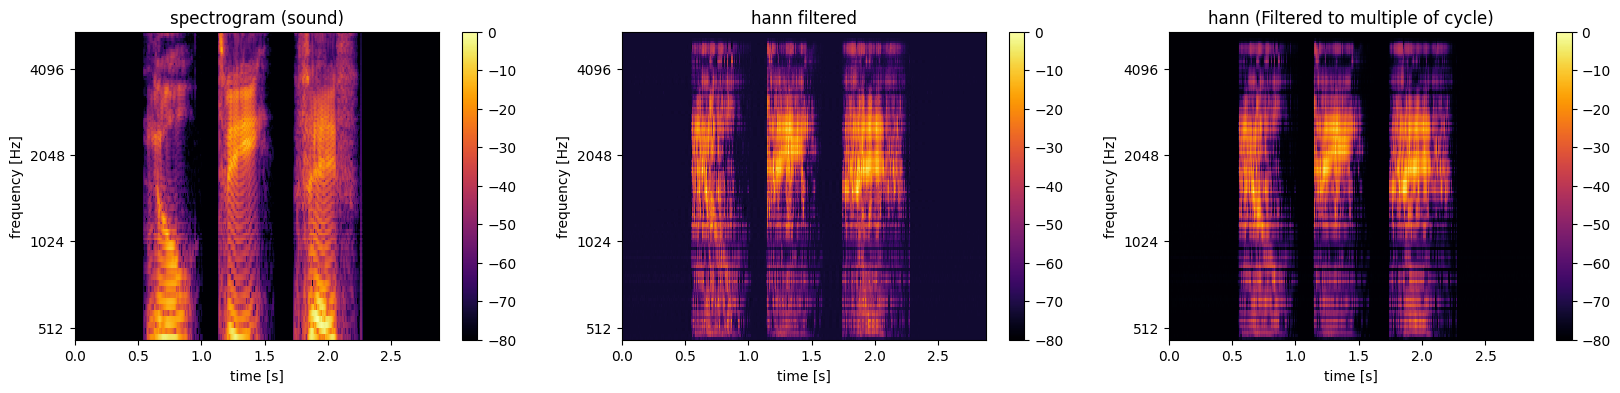

In [8]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 4))

duration = len(audio_signal) * (1 / FS)
S = librosa.feature.melspectrogram(y=audio_signal, sr=FS, n_fft=N_FFT, hop_length=N_HOP, n_mels=N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ)
S_db = librosa.power_to_db(S, ref=np.max)
ts = np.linspace(0, duration, len(S_db[0]))

plotting.plot_heatmap(ts, MEL_SCALE, S_db, ax0, f, show_bands=False)
ax0.set_title("spectrogram (sound)")

filtered_data = utils.apply_filter(neurogram_freq_bin, window_size=1, hop_length=1, clip_outliers=.999, resample_to=S.shape[1], data_max=n_trials)

t = np.linspace(0, duration, len(filtered_data[0]))
plotting.plot_heatmap(t, MEL_SCALE, filtered_data, ax=ax1, fig=f, show_bands=False)
ax1.set_title("hann filtered")


hop_length = int(np.ceil(neurogram_freq_bin.shape[1] / S.shape[1]))
window_size = int(15 * np.floor((hop_length * 4) / 15))
smooth = utils.apply_filter(neurogram_freq_bin, "hann", window_size=window_size, hop_length=hop_length, resample_to=S.shape[1], data_max=n_trials)


ref_db = 65.0
mel_spec_ng = librosa.db_to_power(filtered_data, ref=ref_db)
t = np.linspace(0, duration, len(smooth[0]))
plotting.plot_heatmap(t, MEL_SCALE, smooth, ax=ax2, fig=f, show_bands=False)
ax2.set_title(f"hann (Filtered to multiple of cycle)");
filtered_data.shape

In [9]:
mel_inversed = librosa.feature.inverse.mel_to_audio(mel_spec_ng, n_fft=N_FFT, hop_length=N_HOP, sr=FS, fmin=MIN_FREQ, fmax=MAX_FREQ)

mel_inversed = scipy.signal.resample(mel_inversed, audio_signal.size)

mel_inversed2 = librosa.feature.inverse.mel_to_audio(librosa.db_to_power(smooth, ref=65.0), n_fft=N_FFT, hop_length=N_HOP, sr=FS, fmin=MIN_FREQ, fmax=MAX_FREQ)
mel_inversed2 = scipy.signal.resample(mel_inversed2, audio_signal.size)

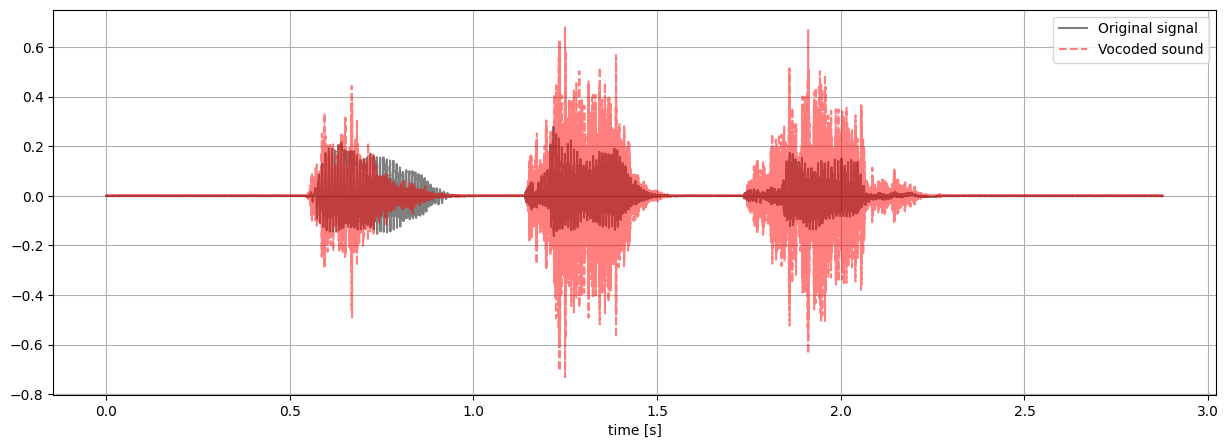

In [10]:
FS = int(FS)
t_audio = np.arange(len(audio_signal)) * 1 / FS
plt.figure(figsize=(15, 5))
plt.plot(t_audio, audio_signal, label="Original signal", color="black", alpha=.5)
plt.xlabel("time [s]")

t_mel = np.arange(len(mel_inversed)) * 1 / FS

plt.plot(
    t_mel, 
    mel_inversed,
    label="Vocoded sound", 
    color ="red", 
    linestyle="dashed", 
    alpha=.5
)

# plt.plot(
#     t_mel, 
#     mel_inversed2,
#     label="inverted spectrogram2", 
#     color ="green", 
#     linestyle="dashed", 
#     alpha=.5
# )


# mel_filt = scipy.signal.savgol_filter(mel_inversed, 16, 2) 
# mel_filt *= (audio_signal.max() - audio_signal.min()) / (mel_filt.max() - mel_filt.min())

# reduced_noise = reduce_noise(mel_inversed2, FS)

# plt.plot(
#     t_mel, reduced_noise,
#     label="inverted spectrogram (filtered)", color ="blue", linestyle="dashed", alpha=.5
# ) 
plt.grid()
plt.legend()

# sf.write(
#     f"output/{NAME}.wav", audio_signal, FS, subtype='PCM_24'
# )

# sf.write(
#     f"output/reconstructed_{NAME}_filt.wav", reduced_noise, FS, subtype='PCM_24'
# )

# sf.write(
#     f"output/{OUTPUT_NAME}_ci.wav", mel_inversed, FS, subtype='PCM_24'
# )

# sf.write(
#     f"output/{OUTPUT_NAME}_ci2.wav", mel_inversed2, FS, subtype='PCM_24'
# )


# n = int(np.ceil(mel_inversed.size * (16000 / FS)))
# mp3 = scipy.signal.resample(mel_inversed, n)
# sf.write(
#         f"output/{OUTPUT_NAME}.mp3", mp3, 16000,
#         format='MP3', subtype='MPEG_LAYER_III'
# )

# n = int(np.ceil(audio_signal.size * (16000 / FS)))
# mp3 = scipy.signal.resample(audio_signal, n)
# sf.write(
#         f"output/{NAME}.mp3", mp3, 16000,
#         format='MP3', subtype='MPEG_LAYER_III'
# )


In [15]:
src, fs = librosa.load("/home/nobeljpde1/abt/notebooks/tripletnoise.wav")

res = librosa.resample(src, orig_sr=fs, target_sr=FS)
sf.write(
    f"tripletnoise_resampled.wav", res, FS, subtype='PCM_24'
)

